## Welcome to the EE4309 2024/25 S1 Lab Project: Object Detection (Inference)


### 1. Load an image and visualize it

(-0.5, 1351.5, 899.5, -0.5)

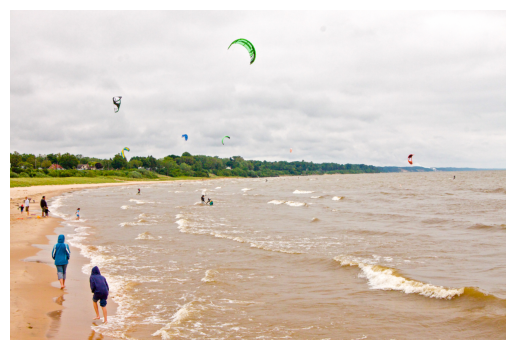

In [2]:
from torchvision.io import read_image
# image = read_image(path='./demo.jpg')
# (1) Now, image is a tensor with uint8 data type. Can you display it in this python notebook? 
### --- Please write you code here --- ###
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
image = Image.open('./demo.jpg')
# Convert to tensor using torchvision transforms
image_tensor = transforms.ToTensor()(image)
plt.imshow(image)
plt.axis('off')
### --- Please write you code here --- ###

### 2. Build a ResNet backbone
This is the first step to implement a Faster R-CNN! We will provide some useful APIs for convenience.


#### 2.1 Useful APIs: conv1x1, conv3x3, Bottleneck, _make_block
Kindly use these functions and classes in the subsequent sections. You may need to complete some key parts on your own.

In [3]:
import torch
from torch import nn

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class Bottleneck(nn.Module):
    expansion: int = 4
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride > 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride),
                nn.BatchNorm2d(planes * self.expansion),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # (2) Please write the pipeline in the bottleneck. It should be 

        # -> conv1 -> bn1 -> relu -> conv2 -> bn2 -> relu -> conv3 -> bn3 -> (add) -> relu ->
        # |                                                                    |
        # |--------------------(may downsample, or identity)-------------------|

        ### --- Please write you code here --- ###
        
        # Save the input tensor
        identity = x

        # The pipeline
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # Apply downsample if needed
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the identity
        out += identity

        # Final ReLU activation
        out = self.relu(out)

        return out
        
        ### --- Please write you code here --- ###
    
def _make_block(
    inplanes: int,
    planes: int,
    blocks: int,
    stride: int = 1,
) -> nn.Module:
    block = [Bottleneck(inplanes, planes, stride)]
    outplanes = planes * Bottleneck.expansion
    for _ in range(1, blocks):
        block.append(Bottleneck(outplanes, planes))
    return nn.Sequential(*block)

#### 2.2 Use provided APIs to build a ResNet
Think carefully, what should be the missing parameters?

In [4]:
class ResNet(nn.Module):
    def __init__(
        self,
        layers: list[int] = [3, 4, 6, 3],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        base_width: int = 64,
    ) -> None:
        super().__init__()
        self.inplanes = base_width

        # (3) Please write some layers before residual blocks: conv2d (ksize = 7, stride=2, padding=3, bias=False) -> bn -> relu -> maxpool(ksize = 3, stride=2, padding=1)
        ### --- Please write you code here --- ###
        
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        ### --- Please write you code here --- ###

        expansion = Bottleneck.expansion
        self.layer1 = _make_block(self.inplanes, 64, layers[0])
        self.layer2 = _make_block(64 * expansion, 128, layers[1], stride=2)
        self.layer3 = _make_block(128 * expansion, 256, layers[2], stride=2)
        self.layer4 = _make_block(256 * expansion, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

resnet = ResNet()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### 2.3. Load the Pre-trained ResNet Checkpoint for Image Recognition

In [5]:
# (4) load checkpoint resnet50.pth to previous resnet
### --- Please write you code here --- ###

import torch

# (4) Load checkpoint resnet50.pth to previous resnet
# Load the state_dict from the checkpoint
checkpoint = torch.load('resnet50.pth')

# Load the state_dict into the resnet model
resnet.load_state_dict(checkpoint)

### --- Please write you code here --- ###
resnet.eval()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22744\1398641943.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet50.pth')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### 2.4 Intermediate Check
Execute the code provided below and observe if the results from the image classification appear reasonable.

In [6]:
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.transforms._presets import ImageClassification

x = ImageClassification(crop_size=224, resize_size=232)(image).unsqueeze(0)
with torch.inference_mode():
    scores = resnet(x).softmax(dim=-1).squeeze_()
sorted_ids = scores.argsort(descending=True).tolist()
for class_id in sorted_ids:
    score = scores[class_id].item()
    category_name = _IMAGENET_CATEGORIES[class_id]
    print(f"{category_name}: {100 * score:.1f}%")

sandbar: 28.4%
parachute: 26.5%
seashore: 20.5%
swimming trunks: 5.7%
volleyball: 3.7%
bathing cap: 2.1%
snorkel: 1.5%
umbrella: 1.4%
paddle: 1.0%
soccer ball: 0.7%
bucket: 0.5%
maillot tank suit: 0.4%
baseball: 0.4%
sunscreen: 0.4%
rugby ball: 0.3%
Lakeland terrier: 0.3%
bikini: 0.3%
maillot: 0.3%
breakwater: 0.2%
tennis ball: 0.2%
lifeboat: 0.2%
lakeside: 0.2%
starfish: 0.2%
Irish terrier: 0.2%
wreck: 0.2%
canoe: 0.2%
sarong: 0.2%
speedboat: 0.1%
redbone: 0.1%
Ibizan hound: 0.1%
amphibian: 0.1%
Rottweiler: 0.1%
coral reef: 0.1%
Rhodesian ridgeback: 0.1%
oystercatcher: 0.1%
Airedale: 0.1%
reel: 0.1%
Norfolk terrier: 0.1%
Chesapeake Bay retriever: 0.1%
Labrador retriever: 0.1%
cliff: 0.1%
catamaran: 0.1%
pelican: 0.1%
leatherback turtle: 0.1%
Doberman: 0.1%
flamingo: 0.1%
diaper: 0.1%
racket: 0.1%
basketball: 0.1%
borzoi: 0.0%
water bottle: 0.0%
conch: 0.0%
promontory: 0.0%
tricycle: 0.0%
ballplayer: 0.0%
sea snake: 0.0%
water jug: 0.0%
hammerhead: 0.0%
whippet: 0.0%
water buffalo: 0.0

### 3. Preprocessing the Image for Object Detection
Until now, our focus has been on image classification. However, before transitioning to object detection, it's essential to preprocess the image appropriately. Typically, object detection requires high-resolution images (e.g., 800x1333), in contrast to the smaller resolutions used for image classification (e.g., 224x224).

#### 3.1 Convert Image Data Type

In [7]:
# (5) torch.uint8 -> torch.float, and ensure 0~1 range

### --- Please write you code here --- ###

import torch
from torchvision.transforms.functional import to_tensor
from PIL import Image

def convert_image_dtype(image, dtype=torch.float32):
    # Ensure the input image is converted to a tensor if it's a PIL Image
    if isinstance(image, Image.Image):
        image = to_tensor(image)

    # Ensure the input image is a tensor
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Expected input to be a torch.Tensor, got {type(image)} instead.")

    # Scale and convert to the desired data type
    return image.float() / 255.0 if dtype == torch.float32 else image.to(dtype)

### --- Please write you code here --- ###

image_float = convert_image_dtype(image_tensor)
print(image_float)

tensor([[[0.0036, 0.0036, 0.0036,  ..., 0.0037, 0.0037, 0.0037],
         [0.0036, 0.0036, 0.0036,  ..., 0.0037, 0.0037, 0.0037],
         [0.0036, 0.0036, 0.0036,  ..., 0.0038, 0.0037, 0.0038],
         ...,
         [0.0034, 0.0035, 0.0035,  ..., 0.0028, 0.0028, 0.0027],
         [0.0034, 0.0034, 0.0035,  ..., 0.0028, 0.0027, 0.0029],
         [0.0035, 0.0035, 0.0035,  ..., 0.0028, 0.0029, 0.0029]],

        [[0.0035, 0.0036, 0.0036,  ..., 0.0037, 0.0037, 0.0037],
         [0.0036, 0.0036, 0.0036,  ..., 0.0037, 0.0037, 0.0037],
         [0.0036, 0.0036, 0.0036,  ..., 0.0037, 0.0037, 0.0037],
         ...,
         [0.0026, 0.0027, 0.0026,  ..., 0.0022, 0.0023, 0.0021],
         [0.0026, 0.0026, 0.0027,  ..., 0.0023, 0.0021, 0.0023],
         [0.0027, 0.0027, 0.0027,  ..., 0.0022, 0.0024, 0.0024]],

        [[0.0035, 0.0036, 0.0036,  ..., 0.0037, 0.0037, 0.0037],
         [0.0036, 0.0036, 0.0036,  ..., 0.0037, 0.0037, 0.0037],
         [0.0036, 0.0036, 0.0036,  ..., 0.0037, 0.0037, 0.

#### 3.2. Resize and Normalize the Image
When resizing images for object detection, it's essential to maintain the original aspect ratio. Given that images can come in various shapes, it's also important to note their original dimensions before resizing them to a consistent scale. To simplify this process, you don't need to write any code. Instead, just run the provided code below.

In [8]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform, ImageList

min_size = 800
max_size = 1333
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)
transform.eval()
images, _ = transform([image_float], targets=None)
print(images, images.tensors.shape)

<torchvision.models.detection.image_list.ImageList object at 0x0000027D46030F10> torch.Size([1, 3, 800, 1216])


The image has been scaled to a minimum edge size of 800. The transformed 'x' is an instance of 'ImageList'. You don't need to be familiar with its internal details; just understand that it represents a structure that holds a list of images (which may vary in size) as a single tensor. x.tensors can access the image's transformed pytorch tensor.

### 4. Constructing a Feature Extractor using ResNet
It's essential to note that ResNet is primarily a classification network, not a detection network. However, in the Faster R-CNN framework, ResNet serves as a feature extractor. Upon this foundation, we can further construct the Region Proposal Network (RPN) and Region of Interest (RoI) sub-network. This section will guide you through this process.


#### 4.1 The Handy API: IntermediateLayerGetter
Suppose we want to retrieve features after the 'layer4' but before 'avgpool'. How can we achieve this? We can utilize an API from torchvision called IntermediateLayerGetter.

In [9]:
from torchvision.models._utils import IntermediateLayerGetter
feature_extractor = IntermediateLayerGetter(resnet, {'layer4': 'feat4'})
features = feature_extractor(images.tensors)
print(features['feat4'].shape)

torch.Size([1, 2048, 25, 38])


As you can see, we successfully extracted the feature map, which has 2048 channels, 25x38 spatial size. (800/32, 1216/32)

#### 4.2 Extract multiple layer features from ResNet


In [1]:
# (6) Please use IntermediateLayerGetter to get multiple layer features. the output should satisfy: 
# '0': layer1 feature, '1': layer2 feature, '2': layer3 feature, '3': layer4 feature

returned_layers = [1,2,3,4]
### --- Please write you code here --- ###

from torchvision.models._utils import IntermediateLayerGetter

# Define the mapping for the layers you want to extract features from
layer_names = {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}

# Use IntermediateLayerGetter to get the specified layers
feature_extractor = IntermediateLayerGetter(resnet, layer_names)

# Assuming 'images.tensors' contains the input tensor
features = feature_extractor(images.tensors)

# Print the shapes of the features from the specified layers
print(features['0'].shape, features['1'].shape, features['2'].shape, features['3'].shape)

### --- Please write you code here --- ###

print(features['0'].shape, features['1'].shape, features['2'].shape, features['3'].shape)

NameError: name 'resnet' is not defined

#### 4.3 Constructing a Feature Pyramid Network (FPN) on the Feature Map
For an introduction to the Feature Pyramid Network, visit this link: https://paperswithcode.com/method/fpn. Note: As this topic isn't covered in our course, you can proceed by directly executing the provided code.

In [10]:
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
class BackboneWithFPN(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        return_layers: dict[str, str],
        in_channels_list: list[int],
        out_channels: int,
    ) -> None:
        super().__init__()

        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=LastLevelMaxPool(),
            norm_layer=nn.BatchNorm2d,
        )
        self.out_channels = out_channels

    def forward(self, x: torch.Tensor) -> dict[str, torch.Tensor]:
        x = self.body(x)
        x = self.fpn(x)
        return x

#### 4.4 Load Pre-trained Checkpoint of the feature extractor and do forward

In [11]:
return_layers = {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}
in_channels_stage2 = resnet.layer1[0].conv1.in_channels * 4

in_channels_list = [int(in_channels_stage2 * 2 ** i) for i in range(len(return_layers))]
out_channels = 256
feature_extractor = BackboneWithFPN(resnet, return_layers, in_channels_list, out_channels)
feature_extractor.load_state_dict(torch.load('feature_extractor.pth'))
feature_extractor.eval()

with torch.no_grad():
    features = feature_extractor(images.tensors)
print([(k, v.shape) for k, v in features.items()])
print(features)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24420\996656605.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature_extractor.load_state_dict(torch.load('feature

[('0', torch.Size([1, 256, 200, 304])), ('1', torch.Size([1, 256, 100, 152])), ('2', torch.Size([1, 256, 50, 76])), ('3', torch.Size([1, 256, 25, 38])), ('pool', torch.Size([1, 256, 13, 19]))]
OrderedDict([('0', tensor([[[[ 0.1381,  0.2262,  0.2382,  ...,  0.1335,  0.1507,  0.0497],
          [ 0.0951,  0.1974,  0.2279,  ...,  0.0969,  0.1665,  0.0675],
          [ 0.0495,  0.1078,  0.1236,  ...,  0.0488,  0.1237,  0.0456],
          ...,
          [-0.1132, -0.1824, -0.1426,  ..., -0.1188, -0.0454, -0.0686],
          [-0.0822, -0.1312, -0.0964,  ..., -0.0897, -0.0347, -0.0721],
          [-0.0336, -0.0469, -0.0354,  ..., -0.0502, -0.0364, -0.0868]],

         [[-0.2889, -0.0372, -0.0938,  ..., -0.1811, -0.2828, -0.4561],
          [-0.2379, -0.0739, -0.2492,  ..., -0.2278, -0.4291, -0.5214],
          [-0.2363, -0.1255, -0.3085,  ..., -0.1895, -0.2787, -0.5791],
          ...,
          [-0.3960, -0.3504, -0.4392,  ..., -0.2367, -0.2804, -0.4228],
          [-0.4571, -0.0942, -0.2003

### 5. Build Anchor Boxes and Region Proposal Network (RPN) on the Feature Map
In this section, we will construct the Anchor Boxes and the Region Proposal Network (RPN) on the feature map. This represents the 'region proposal' step, which is the 1st stage in Faster R-CNN.

#### 5.1 Build Anchor Boxes Generator
An anchor box is essentially a predefined bounding box shape (i.e., width and height) at a specific location in the image. For a given feature map location, multiple anchor boxes (of different shapes/sizes) can be associated. To detect objects of various sizes and aspect ratios, anchor boxes are defined at multiple scales and aspect ratios. For example, at a single feature map location, you might have three scales and three aspect ratios, yielding nine anchor boxes. 

Writing code to generate anchor boxes can be tedious. Please execute the following code and examine the resulting anchor boxes.

In [12]:
from torchvision.models.detection.anchor_utils import AnchorGenerator
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
anchors = rpn_anchor_generator(images, list(features.values()))
print(anchors[0], anchors[0].shape) # we only have 1 image, so index 0

tensor([[ -23.,  -11.,   23.,   11.],
        [ -16.,  -16.,   16.,   16.],
        [ -11.,  -23.,   11.,   23.],
        ...,
        [ 790.,  551., 1514.,  913.],
        [ 896.,  476., 1408.,  988.],
        [ 971.,  370., 1333., 1094.]]) torch.Size([242991, 4])


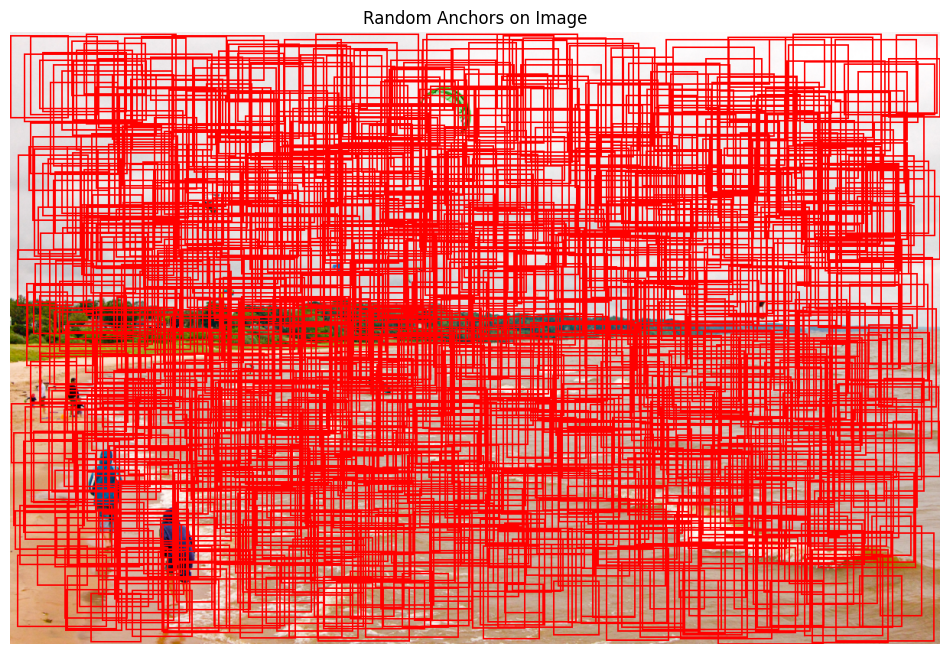

In [13]:
import random
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize, to_tensor
from torchvision.utils import draw_bounding_boxes
from PIL import Image

# Function to generate random anchor boxes
def generate_random_anchors(num_anchors, image_width, image_height):
    anchors = []
    for _ in range(num_anchors):
        # Randomly select width, height and top-left corner of the anchor
        width = random.randint(50, 150)   # Random width between 50 and 150 pixels
        height = random.randint(50, 150)  # Random height between 50 and 150 pixels
        x = random.randint(0, image_width - width)
        y = random.randint(0, image_height - height)
        anchors.append((x, y, x + width, y + height))
    return anchors

# Visualize random anchors on the image using draw_bounding_boxes
def visualize_anchors(image, anchors):
    # Convert the image tensor to [B, C, H, W] format
    image_with_bboxes = draw_bounding_boxes(image, boxes=torch.tensor(anchors), colors="red", width=2)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image_with_bboxes.permute(1, 2, 0).cpu().numpy())  # Convert CHW to HWC for plotting
    plt.axis('off')
    plt.title('Random Anchors on Image')
    plt.show()

# Ensure the input image is loaded or available as image_tensor
if isinstance(image_tensor, Image.Image):
    image_tensor = to_tensor(image_tensor)

# Resize the image for visualization
image_just_for_vis = resize(image_tensor, (800, 1216))

# Generate 1000 random anchors
num_random_anchors = 1000
image_width = image_just_for_vis.shape[2]
image_height = image_just_for_vis.shape[1]
random_anchors = generate_random_anchors(num_random_anchors, image_width, image_height)

# Visualize the anchors
visualize_anchors(image_just_for_vis, random_anchors)


#### 5.2 Build RPN Head Network

In [14]:
# (8) Please complete RPNHead __init__ and forward function.

from torchvision.ops import Conv2dNormActivation
class RPNHead(nn.Module):
    """
    Adds a simple RPN Head with classification and regression heads

    Args:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
        conv_depth (int, optional): number of convolutions
    """
    def __init__(self, in_channels: int, num_anchors: int, conv_depth=1) -> None:
        super().__init__()
        
        convs = []
        for _ in range(conv_depth):
            convs.append(Conv2dNormActivation(in_channels, in_channels, kernel_size=3, norm_layer=None))
        self.conv = nn.Sequential(*convs)
        ### --- Please write you code here --- ###
        self.cls_logits = nn.Conv2d(in_channels, num_anchors, kernel_size=1)
        self.bbox_pred = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)
        ### --- Please write you code here --- ###

        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                torch.nn.init.normal_(layer.weight, std=0.01) 
                if layer.bias is not None:
                    torch.nn.init.constant_(layer.bias, 0) 

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            for type in ["weight", "bias"]:
                old_key = f"{prefix}conv.{type}"
                new_key = f"{prefix}conv.0.0.{type}"
                if old_key in state_dict:
                    state_dict[new_key] = state_dict.pop(old_key)

        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )

    def forward(self, x: list[torch.Tensor]) -> tuple[list[torch.Tensor], list[torch.Tensor]]:
        cls_logits = []
        bbox_reg = []
        for feature in x: # feature from multi layers
            ### --- Please write you code here --- ###
            t = self.conv(feature)
            cls_logits.append(self.cls_logits(t))
            bbox_reg.append(self.bbox_pred(t))
            ### --- Please write you code here --- ###
        return cls_logits, bbox_reg

rpn_head = RPNHead(feature_extractor.out_channels, rpn_anchor_generator.num_anchors_per_location()[0], conv_depth=2)
print(rpn_head)
rpn_head.load_state_dict(torch.load('rpn_head.pth'))
objectness, pred_bbox_deltas = rpn_head(list(features.values()))
print('objectness shape', [o.shape for o in objectness])
print('pred_bbox_deltas shape', [b.shape for b in pred_bbox_deltas])

RPNHead(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
  (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24420\1024751618.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rpn_head.load_state_dict(torch.load('rpn_head.pth')

objectness shape [torch.Size([1, 3, 200, 304]), torch.Size([1, 3, 100, 152]), torch.Size([1, 3, 50, 76]), torch.Size([1, 3, 25, 38]), torch.Size([1, 3, 13, 19])]
pred_bbox_deltas shape [torch.Size([1, 12, 200, 304]), torch.Size([1, 12, 100, 152]), torch.Size([1, 12, 50, 76]), torch.Size([1, 12, 25, 38]), torch.Size([1, 12, 13, 19])]


#### 5.3 Build Region Proposal Pipeline

In [15]:
import math

# (9) First, we implement how to adjust anchor box by the outputs from RPNHead.

class BoxCoder:
    """
    This class encodes and decodes a set of bounding boxes into
    the representation used for training the regressors.
    """

    def __init__(
        self, weights: tuple[float, float, float, float], bbox_xform_clip: float = math.log(1000.0 / 16)
    ) -> None:
        """
        Args:
            weights (4-element tuple)
            bbox_xform_clip (float)
        """
        self.weights = weights
        self.bbox_xform_clip = bbox_xform_clip

    def decode(self, rel_codes: torch.Tensor, boxes: list[torch.Tensor]) -> torch.Tensor:
        torch._assert(
            isinstance(boxes, (list, tuple)),
            "This function expects boxes of type list or tuple.",
        )
        torch._assert(
            isinstance(rel_codes, torch.Tensor),
            "This function expects rel_codes of type torch.Tensor.",
        )
        boxes_per_image = [b.size(0) for b in boxes]
        concat_boxes = torch.cat(boxes, dim=0)
        box_sum = 0
        for val in boxes_per_image:
            box_sum += val
        if box_sum > 0:
            rel_codes = rel_codes.reshape(box_sum, -1)
        
        concat_boxes = concat_boxes.to(rel_codes.dtype)

        widths = concat_boxes[:, 2] - concat_boxes[:, 0]
        heights = concat_boxes[:, 3] - concat_boxes[:, 1]
        ctr_x = concat_boxes[:, 0] + 0.5 * widths
        ctr_y = concat_boxes[:, 1] + 0.5 * heights

        wx, wy, ww, wh = self.weights
        dx = rel_codes[:, 0::4] / wx
        dy = rel_codes[:, 1::4] / wy
        dw = rel_codes[:, 2::4] / ww
        dh = rel_codes[:, 3::4] / wh

        # Prevent sending too large values into torch.exp()
        dw = torch.clamp(dw, max=self.bbox_xform_clip)
        dh = torch.clamp(dh, max=self.bbox_xform_clip)
        
        ### --- Please write you code here --- ###
        pred_ctr_x = ctr_x[:, None] + dx * widths[:, None]
        pred_ctr_y = ctr_y[:, None] + dy * heights[:, None]
        pred_w = torch.exp(dw) * widths[:, None]
        pred_h = torch.exp(dh) * heights[:, None]
        pred_boxes = torch.zeros_like(rel_codes)
        pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
        pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
        pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
        pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h

        ### --- Please write you code here --- ###

        if box_sum > 0:
            pred_boxes = pred_boxes.reshape(box_sum, -1, 4)
        return pred_boxes
    
num_images = len(anchors)
num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
from torchvision.models.detection.rpn import concat_box_prediction_layers
objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
proposals = BoxCoder((1,1,1,1)).decode(pred_bbox_deltas.detach(), anchors)
print(anchors, proposals)

[tensor([[ -23.,  -11.,   23.,   11.],
        [ -16.,  -16.,   16.,   16.],
        [ -11.,  -23.,   11.,   23.],
        ...,
        [ 790.,  551., 1514.,  913.],
        [ 896.,  476., 1408.,  988.],
        [ 971.,  370., 1333., 1094.]])] tensor([[[-1.0460e+01, -1.0142e+00,  1.6111e+00,  4.1824e+00]],

        [[-1.7194e+01, -1.8505e+01,  1.6880e+01,  1.3281e+01]],

        [[-3.4976e+00, -5.5256e+00,  1.3048e+00,  9.3707e+00]],

        ...,

        [[ 9.8007e+02,  6.9565e+02,  1.3741e+03,  8.4839e+02]],

        [[ 9.2279e+02,  5.3059e+02,  1.3936e+03,  9.5945e+02]],

        [[ 1.0824e+03,  6.3897e+02,  1.2454e+03,  9.3869e+02]]])


You can see the original anchors have been adjusted. After anchor boxes are justed by the RPNHead bounding-box regression outputs, we should filter most anchor boxes by its class scores (only maintain top 1000) and then perform NMS algorithm to them. If implementing from scratch, it will take a lot of time. Please directly run the following code.

In [16]:
rpn_pre_nms_top_n_test = 1000
rpn_post_nms_top_n_test = 1000
small_box_min_size = 1e-3
rpn_nms_thresh = 0.7
rpn_score_thresh = 0.0

from torchvision import ops as box_ops
from torchvision.models.detection._utils import _topk_min

def _get_top_n_idx(objectness: torch.Tensor, num_anchors_per_level: list[int]) -> torch.Tensor:
    r = []
    offset = 0
    for ob in objectness.split(num_anchors_per_level, 1):
        num_anchors = ob.shape[1]
        pre_nms_top_n = _topk_min(ob, rpn_pre_nms_top_n_test, 1)
        _, top_n_idx = ob.topk(pre_nms_top_n, dim=1)
        r.append(top_n_idx + offset)
        offset += num_anchors
    return torch.cat(r, dim=1)

def filter_proposals(
    proposals: torch.Tensor,
    objectness: torch.Tensor,
    image_shapes: list[tuple[int, int]],
    num_anchors_per_level: list[int],
) -> tuple[list[torch.Tensor], tuple[torch.Tensor]]:

    num_images = proposals.shape[0]
    device = proposals.device
    objectness = objectness.detach()
    objectness = objectness.reshape(num_images, -1)

    levels = [
        torch.full((n,), idx, dtype=torch.int64, device=device) for idx, n in enumerate(num_anchors_per_level)
    ]
    levels = torch.cat(levels, 0)
    levels = levels.reshape(1, -1).expand_as(objectness)

    # select top_n boxes independently per level before applying nms
    top_n_idx = _get_top_n_idx(objectness, num_anchors_per_level)

    image_range = torch.arange(num_images, device=device)
    batch_idx = image_range[:, None]

    objectness = objectness[batch_idx, top_n_idx]
    levels = levels[batch_idx, top_n_idx]
    proposals = proposals[batch_idx, top_n_idx]

    objectness_prob = torch.sigmoid(objectness)

    final_boxes = []
    final_scores = []
    for boxes, scores, lvl, img_shape in zip(proposals, objectness_prob, levels, image_shapes):
        boxes = box_ops.clip_boxes_to_image(boxes, img_shape)

        # remove small boxes
        keep = box_ops.remove_small_boxes(boxes, small_box_min_size)
        boxes, scores, lvl = boxes[keep], scores[keep], lvl[keep]

        # remove low scoring boxes
        # use >= for Backwards compatibility
        keep = torch.where(scores >= rpn_score_thresh)[0]
        boxes, scores, lvl = boxes[keep], scores[keep], lvl[keep]

        # non-maximum suppression, independently done per level
        keep = box_ops.batched_nms(boxes, scores, lvl, rpn_nms_thresh)

        # keep only topk scoring predictions
        keep = keep[:rpn_post_nms_top_n_test]
        boxes, scores = boxes[keep], scores[keep]

        final_boxes.append(boxes)
        final_scores.append(scores)
    return final_boxes, final_scores

proposals = proposals.view(num_images, -1, 4)
proposals, scores = filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)
print('proposals shape', [p.shape for p in proposals])
print('scores shape', [s.shape for s in scores])

proposals shape [torch.Size([857, 4])]
scores shape [torch.Size([857])]


#### 5.4 Visualize the proposed region

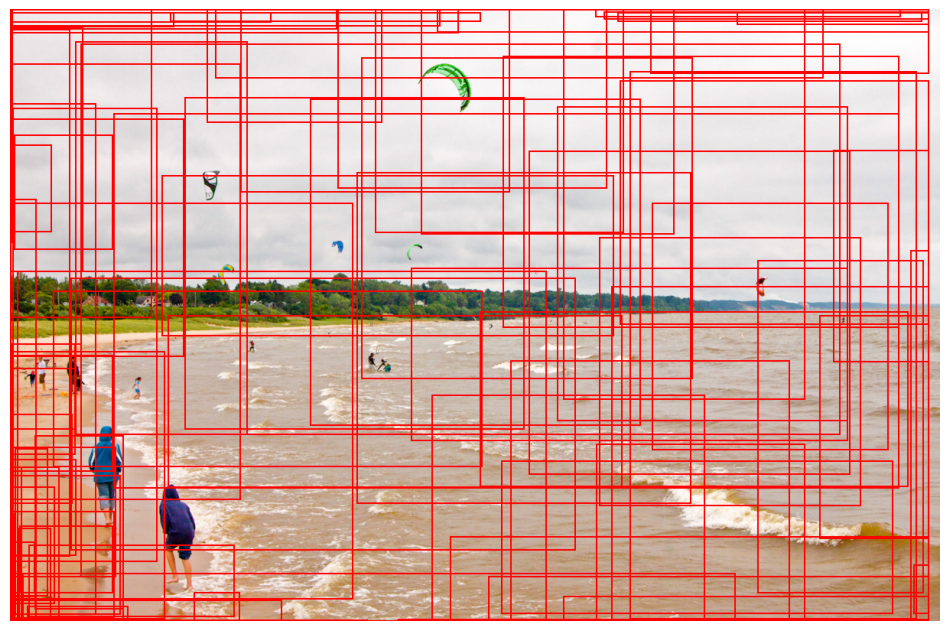

In [17]:
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image, pil_to_tensor

### --- Please write you code here --- ###

# Get the proposals for the first image (assuming batch size of 1)
proposals_for_image = proposals[0]  # Shape: [num_boxes, num_preds_per_box, 4]

# If proposals have an extra dimension, reshape them
proposals_for_image = proposals_for_image.reshape(-1, 4)

# Clamp proposals to be within image bounds
height, width = image_just_for_vis.shape[1], image_just_for_vis.shape[2]
proposals_for_image[:, [0, 2]] = proposals_for_image[:, [0, 2]].clamp(0, width)
proposals_for_image[:, [1, 3]] = proposals_for_image[:, [1, 3]].clamp(0, height)

# Convert proposals to CPU and int type
proposals_for_image = proposals_for_image.detach().cpu().int()

# Ensure the image has 3 channels
if image_just_for_vis.shape[0] == 1:
    image_to_show = image_just_for_vis.repeat(3, 1, 1)
else:
    image_to_show = image_just_for_vis.clone()

# Convert the image tensor to PIL image
image_to_show = to_pil_image(image_to_show)

# Convert image back to tensor with values between 0 and 255
image_to_show_tensor = pil_to_tensor(image_to_show)

# If there are too many proposals, sample a subset to visualize
if proposals_for_image.shape[0] > 100:
    indices = torch.randperm(proposals_for_image.shape[0])[:100]
    proposals_for_image = proposals_for_image[indices]

# Draw bounding boxes on the image
image_with_boxes = draw_bounding_boxes(
    image_to_show_tensor,
    boxes=proposals_for_image,
    colors="red",
    width=2
)

# Convert the image back to PIL format for visualization
image_with_boxes = to_pil_image(image_with_boxes)

# Display the image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()

### --- Please write you code here --- ###

### 6. RoI Align and Subnetwork
Congratulations! You've successfully generated region proposals. The subsequent step involves using the RoI Align and RoI-subnetwork to refine these proposal boxes and classify the object's category. This process is much simpler than region proposal network.

#### 6.1 Multi-scale RoI Align

In [18]:
from torchvision.ops import MultiScaleRoIAlign
box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2)

# NOTE: RoI align does not have learnable parameters

box_features = box_roi_pool(features, proposals, images.image_sizes)
print(box_features.shape)

torch.Size([857, 256, 7, 7])


#### 6.2 Box Head and Box Predictor
Box head is defined as the network before RoI Network outputs class and bounding-box regression results --- it is used to enhance the feature. Box predictor has two linear layers, one for bounding-box regression and one for classification.

In [19]:
from torchvision.models.detection.faster_rcnn import FastRCNNConvFCHead
box_head = FastRCNNConvFCHead(
    (feature_extractor.out_channels, 7, 7), [256, 256, 256, 256], [1024], norm_layer=nn.BatchNorm2d
)
box_head.load_state_dict(torch.load('box_head.pth'))
box_head.eval()

box_features = box_head(box_features)
print(box_features.shape)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24420\1210666893.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  box_head.load_state_dict(torch.load('box_head.pth'))

torch.Size([857, 1024])


In [20]:
# (11) Please implement box_predictor

class BoxPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    
    Inputs: 
        x (torch.Tensor): with shape num_rois x channels 

    Returns:
        scores (torch.Tensor) 
        bbox_deltas (torch.Tensor)

    Layers:
        self.cls_score: nn.Linear 
        self.bbox_pred: nn.Linear
    """
    ### --- Please write you code here --- ###

    def __init__(self, in_channels, num_classes):
        super(BoxPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas
    
    ### --- Please write you code here --- ###

representation_size = 1024
num_classes = 91
box_predictor = BoxPredictor(representation_size, num_classes)
box_predictor.load_state_dict(torch.load('box_predictor.pth'))
box_predictor.eval()

class_logits, box_regression = box_predictor(box_features)
print(class_logits.shape, box_regression.shape)

torch.Size([857, 91]) torch.Size([857, 364])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24420\1071418970.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  box_predictor.load_state_dict(torch.load('box_predi

#### 6.3 Get Detection Results

In [21]:
# (12) This is a final check. If success, you will see many objects will be detected in the image
from torchvision.utils import draw_bounding_boxes
from torchvision.models._meta import _COCO_CATEGORIES
from torchvision.transforms.functional import to_pil_image

box_score_thresh = 0.05
box_nms_thresh = 0.5
box_detections_per_img = 100

def postprocess_detections(
    class_logits,  
    box_regression,  
    proposals,  
    image_shapes, 
):
    device = class_logits.device
    num_classes = class_logits.shape[-1]

    boxes_per_image = [boxes_in_image.shape[0] for boxes_in_image in proposals]
    pred_boxes = BoxCoder((10.0, 10.0, 5.0, 5.0)).decode(box_regression, proposals)

    pred_scores = torch.softmax(class_logits, -1)

    pred_boxes_list = pred_boxes.split(boxes_per_image, 0)
    pred_scores_list = pred_scores.split(boxes_per_image, 0)

    all_boxes = []
    all_scores = []
    all_labels = []
    for boxes, scores, image_shape in zip(pred_boxes_list, pred_scores_list, image_shapes):
        boxes = box_ops.clip_boxes_to_image(boxes, image_shape)

        # create labels for each prediction
        labels = torch.arange(num_classes, device=device)
        labels = labels.view(1, -1).expand_as(scores)

        # remove predictions with the background label
        boxes = boxes[:, 1:]
        scores = scores[:, 1:]
        labels = labels[:, 1:]

        # batch everything, by making every class prediction be a separate instance
        boxes = boxes.reshape(-1, 4)
        scores = scores.reshape(-1)
        labels = labels.reshape(-1)

        # remove low scoring boxes
        inds = torch.where(scores > box_score_thresh)[0]
        boxes, scores, labels = boxes[inds], scores[inds], labels[inds]

        # remove empty boxes
        keep = box_ops.remove_small_boxes(boxes, min_size=1e-2)
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        # non-maximum suppression, independently done per class
        keep = box_ops.batched_nms(boxes, scores, labels, box_nms_thresh)
        # keep only topk scoring predictions
        keep = keep[: box_detections_per_img]
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        all_boxes.append(boxes)
        all_scores.append(scores)
        all_labels.append(labels)

    return all_boxes, all_scores, all_labels

boxes, scores, labels = postprocess_detections(class_logits, box_regression, proposals, images.image_sizes)
boxes, scores, labels = boxes[0], scores[0], labels[0] # we only have one image
detections = [{'boxes': boxes, 'scores': scores, 'labels': labels}]
detections = transform.postprocess(detections, images.image_sizes, [(image.shape[-2], image.shape[-1])])
boxes, scores, labels = detections[0]['boxes'], detections[0]['scores'], detections[0]['labels']
labels = [_COCO_CATEGORIES[label.item()] + f': {score:.3f}' for label, score in zip(labels, scores)]
vis = draw_bounding_boxes(image, boxes, labels=labels)
display(to_pil_image(vis))


AttributeError: shape